# Internet News and User Engagement

![breaking_news_image](pic.jpg)

## Introduction
You have a friend who works as a reporter for BBC news. He's been disappointed in his articles' low Facebook engagement and that his articles have never been listed as top articles on the BBC. You've offered your help by finding data-driven recommendations on how he should position his articles (such as guidelines on title and description) and when in the day he should publish articles. He's interested in what makes a top article at BBC and what gets the most Facebook engagement.

He's also interested in learning:
- which publishers and authors publish the most content?
- which publishers and authors publish the most engaging content?
- the most popular words used in the titles and descriptions of articles
- any common events or themes present on days where total engagement was higher than usual

He has provided you with a dataset on news articles published between early September to early October 2019 enriched by Facebook engagement data, such as the number of shares, comments, and reactions. He noted that the dataset was initally created to predict the popularity of an article before it was published.

**Data dictionary**

|    | Variable                        | Description                                                                  |
|---:|:--------------------------------|:-----------------------------------------------------------------------------|
|  0 | source_id                       | publisher unique identifier                                                  |
|  1 | source_name                     | human-readable publisher name                                                |
|  2 | author                          | article author                                                               |
|  3 | title                           | article headline                                                             |
|  4 | description                     | article short description                                                    |
|  5 | url                             | article URL from publisher website                                           |
|  6 | url_to_image                    | url to main image associated with the article                                |
|  7 | published_at                    | exact time and date of publishing the article                                |
|  8 | content                         | unformatted content of the article truncated to 260 characters               |
|  9 | top_article                     | value indicating if article was listed as a top article on publisher website |
| 10 | engagement_reaction_count       | users reactions count for posts on Facebook involving article URL            |
| 11 | engagement_comment_count        | users comments count for posts on Facebook involving article URL             |
| 12 | engagement_share_count          | users shares count for posts on Facebook involving article URL               |
| 13 | engagement_comment_plugin_count | users comments count for Facebook comment plugin on article website          |

[Source: Internet articles with users engagement](https://www.kaggle.com/szymonjanowski/internet-articles-data-with-users-engagement).

In [29]:
# general data wrangling etc
import datetime as dt
import math
import missingno as msno
import numpy as np
import pandas as pd
from pprint import pprint
from scipy.stats import pearsonr, spearmanr

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud

# general text pre & postprocessing
import collections
from imblearn.over_sampling import *
from imblearn.under_sampling import *
import nltk
from nltk.tokenize import RegexpTokenizer
import re

# feature engineering
from textblob import TextBlob # sentiment
import spacy # named entity recognition

# topic modelling
import gensim # topic modelling
from gensim import models as gensim_models
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# word-embedding
import gensim.downloader as gensim_api
# BoW (tf-idf)
from imblearn.pipeline import make_pipeline
from sklearn import feature_selection, feature_extraction, manifold, metrics as smetrics, model_selection, naive_bayes, pipeline, \
    preprocessing as sprocessing
# deep learning
from tensorflow.keras import backend as K, callbacks, initializers, layers, metrics as kmetrics, models, optimizers, preprocessing as kprocessing
# BERT
import tensorflow as tf
import transformers

In [3]:
!spacy download en_core_web_lg

2023-04-18 03:53:33.102492: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-18 03:53:33.102524: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-18 03:53:33.102551: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (05d633ea-2cc8-4e22-8027-b89f4a645bb9): /proc/driver/nvidia/version does not exist
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.4 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python3 -m pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [4]:
news = pd.read_csv("news_articles.csv", index_col=0)

In [5]:
# parse the datetimes correctly
def parse_date(string):
    try:
        return dt.datetime.strptime(string, "%Y-%m-%dT%H:%M:%SZ")
    except:
        try:
            return dt.datetime.strptime(string, "%Y-%m-%dT%H:%M:%S.%fZ")
        except:
            return string

news['published_at'] = news['published_at'].apply(lambda x: parse_date(x))

# add date and time components
news['published_month'] = news['published_at'].apply(lambda x: x.month)
news['published_month_name'] = news['published_at'].apply(lambda x: x.month_name())
news['published_month_name'] = pd.Categorical(news['published_month_name'], ordered=True, categories=['September', 'October'])
news['published_day'] = news['published_at'].apply(lambda x: x.day)
news['published_dayofweek_name'] = news['published_at'].apply(lambda x: x.day_name())
news['published_dayofweek_name'] = pd.Categorical(news['published_dayofweek_name'], ordered=True,
                                                  categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
news['published_dayofweek'] = news['published_at'].apply(lambda x: x.dayofweek+1)
news['published_hour'] = news['published_at'].apply(lambda x: x.hour)
news['published_minute'] = news['published_at'].apply(lambda x: x.minute)

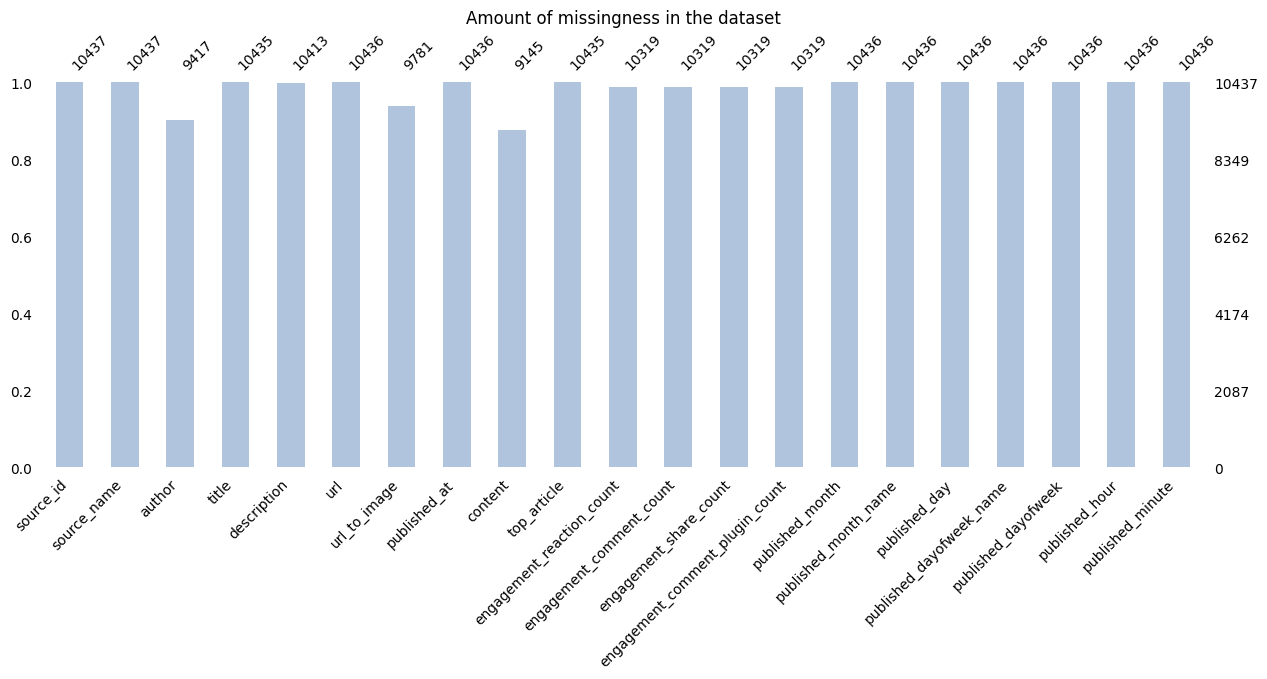

In [6]:
# assess missingness
fig, ax = plt.subplots(figsize=(15, 5))
msno.bar(news, fontsize=10, color='lightsteelblue', ax=ax)
ax.set_title("Amount of missingness in the dataset");

This plot indicates that there is only a relatively small amount of missing data in the dataset and that it is most prevalent in the author, content and url_to_image variables. There are two observations with missing values for the top_article variable, which will be removed as this variable is the one we are trying to predict for part A. We may also consider removing observations with missing titles or descriptions as they are also key variables we wish to use in our analysis.

In [7]:
# remove missing top_article rows
news = news.dropna(subset='top_article')
# replace missing author names with "Unknown"
news.author = news.author.fillna(value="Unknown")
# fill missing values in the engagement variables with 0
for col in [col for col in news.columns if col.startswith('engagement')]:
    news[col].fillna(0, inplace=True)
# check if there are any rows missing both a title and a description
if news[news[['title', 'description']].isnull().all(axis=1)].shape[0] > 0:
    news = news.dropna(subset=['title', 'description'])

# add overall engagement variables
news['engagement_total_count'] = news.engagement_reaction_count + news.engagement_comment_count + news.engagement_share_count + news.engagement_comment_plugin_count
news['engagement_score'] = np.log1p(news.engagement_total_count)

## Question 1: What publishers and authors publish the most content based on this dataset? How about most engaging content?

In [7]:
print(round(news.source_name.value_counts(normalize=True), 4))
print('-----')
print(news.author.value_counts().head(10))

Reuters                    0.1200
BBC News                   0.1190
The Irish Times            0.1181
ABC News                   0.1092
CNN                        0.1085
Business Insider           0.1004
The New York Times         0.0944
CBS News                   0.0912
Newsweek                   0.0517
Al Jazeera English         0.0478
The Wall Street Journal    0.0319
ESPN                       0.0079
Name: source_name, dtype: float64
-----
Unknown                             1020
The Associated Press                 975
Reuters Editorial                    685
CBS News                             637
https://www.facebook.com/bbcnews     533
Al Jazeera                           312
The Irish Times                      255
BBC News                             201
CBS/AP                                69
Dan Cancian                           45
Name: author, dtype: int64


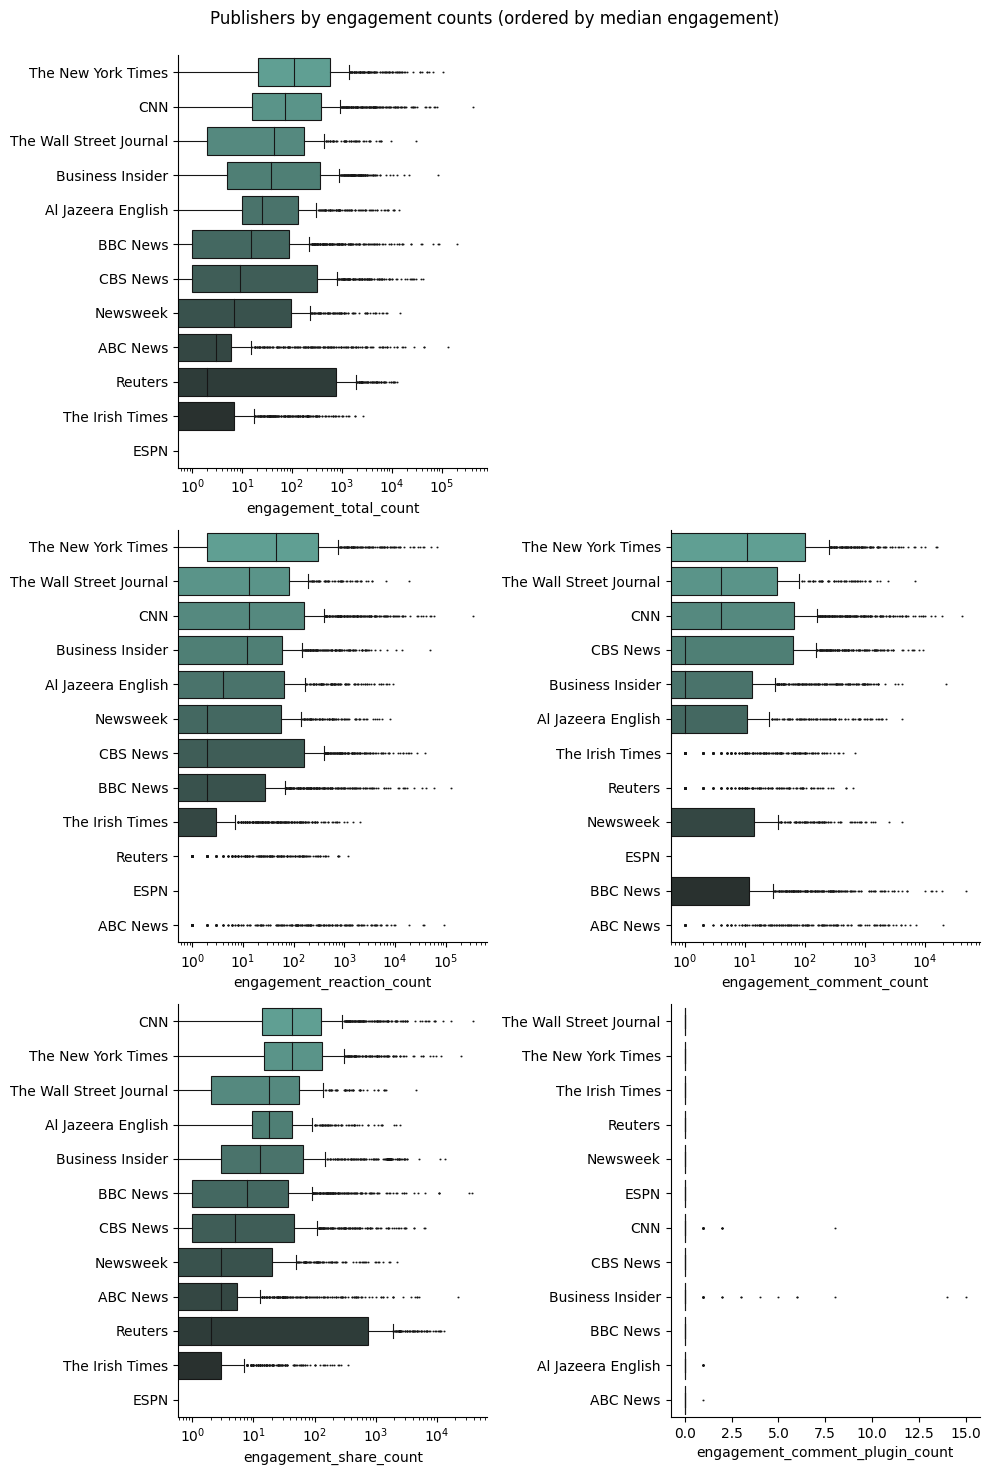

In [8]:
fig, ax = plt.subplots(3,2, figsize=(10,15))
fig.delaxes(ax[0][1])
news_pal = sns.color_palette("dark:#5A9_r", n_colors=12)

tot = news.groupby(["source_name"])['engagement_total_count'].median().iloc[::-1].sort_values(ascending=False)
sns.boxplot(x="engagement_total_count", y="source_name", data=news, order=tot.index, fliersize=0.5, linewidth=0.8, palette=news_pal, ax=ax[0,0])
ax[0,0].set_xscale("log")
ax[0,0].set_ylabel(None)

react = news.groupby(["source_name"])['engagement_reaction_count'].median().iloc[::-1].sort_values(ascending=False)
sns.boxplot(x="engagement_reaction_count", y="source_name", data=news, order=react.index, fliersize=0.5, linewidth=0.8, palette=news_pal, ax=ax[1,0])
ax[1,0].set_xscale("log")
ax[1,0].set_ylabel(None)

comm = news.groupby(["source_name"])['engagement_comment_count'].median().iloc[::-1].sort_values(ascending=False)
sns.boxplot(x="engagement_comment_count", y="source_name", data=news, order=comm.index, fliersize=0.5, linewidth=0.8, palette=news_pal, ax=ax[1,1])
ax[1,1].set_xscale("log")
ax[1,1].set_ylabel(None)

share = news.groupby(["source_name"])['engagement_share_count'].median().iloc[::-1].sort_values(ascending=False)
sns.boxplot(x="engagement_share_count", y="source_name", data=news, order=share.index, fliersize=0.5, linewidth=0.8, palette=news_pal, ax=ax[2,0])
ax[2,0].set_xscale("log")
ax[2,0].set_ylabel(None)

plug = news.groupby(["source_name"])['engagement_comment_plugin_count'].median().iloc[::-1].sort_values(ascending=False)
sns.boxplot(x="engagement_comment_plugin_count", y="source_name", data=news, order=plug.index, fliersize=0.5, linewidth=0.8, palette=news_pal, ax=ax[2,1])
ax[2,1].set_ylabel(None)

sns.despine()
plt.suptitle("Publishers by engagement counts (ordered by median engagement)")
plt.tight_layout()
plt.subplots_adjust(top=0.95);

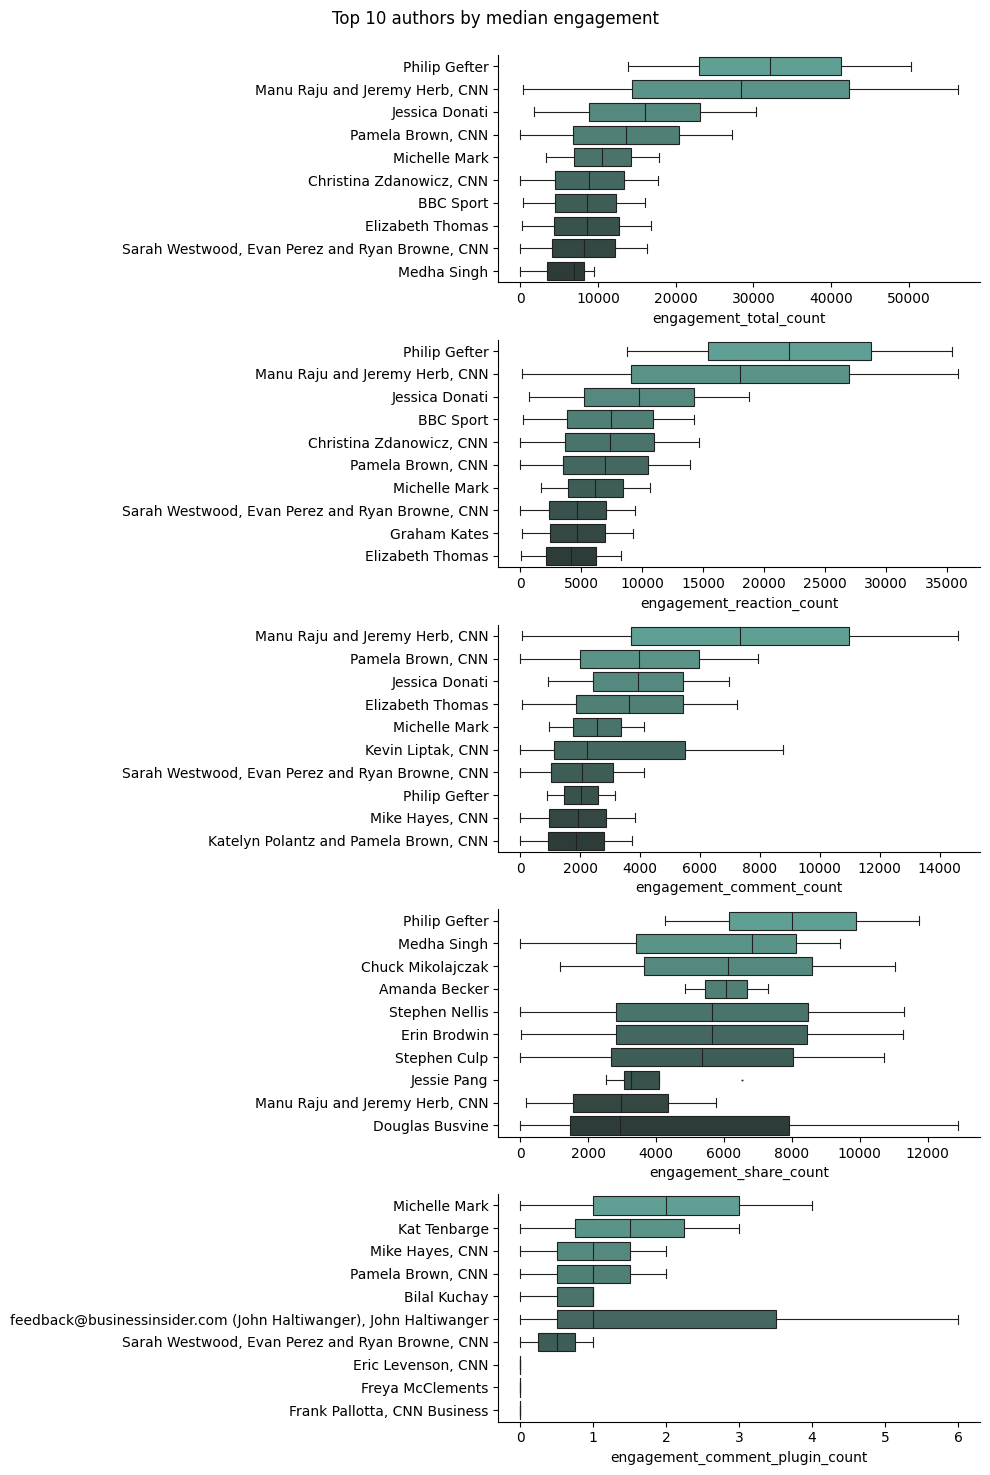

In [9]:
# reduce the dataset to only those authors with 2+ articles
news['num_author_articles'] = news.groupby('author')['author'].transform('count')
news_sub = news.loc[news.num_author_articles > 1]

fig, ax = plt.subplots(5,1, figsize=(10,15))
news_pal = sns.color_palette("dark:#5A9_r", n_colors=12)

tot = news_sub.groupby(["author"])['engagement_total_count'].median().iloc[::-1].sort_values(ascending=False)[:10]
sns.boxplot(x="engagement_total_count", y="author", data=news_sub, order=tot.index, fliersize=0.5, linewidth=0.8, palette=news_pal, ax=ax[0])
# ax[0].set_xscale("log")
ax[0].set_ylabel(None)

react = news_sub.groupby(["author"])['engagement_reaction_count'].median().iloc[::-1].sort_values(ascending=False)[:10]
sns.boxplot(x="engagement_reaction_count", y="author", data=news_sub, order=react.index, fliersize=0.5, linewidth=0.8, palette=news_pal, ax=ax[1])
# ax[1].set_xscale("log")
ax[1].set_ylabel(None)

comm = news_sub.groupby(["author"])['engagement_comment_count'].median().iloc[::-1].sort_values(ascending=False)[:10]
sns.boxplot(x="engagement_comment_count", y="author", data=news_sub, order=comm.index, fliersize=0.5, linewidth=0.8, palette=news_pal, ax=ax[2])
ax[2].set_ylabel(None)

share = news_sub.groupby(["author"])['engagement_share_count'].median().iloc[::-1].sort_values(ascending=False)[:10]
sns.boxplot(x="engagement_share_count", y="author", data=news_sub, order=share.index, fliersize=0.5, linewidth=0.8, palette=news_pal, ax=ax[3])
ax[3].set_ylabel(None)

plug = news_sub.groupby(["author"])['engagement_comment_plugin_count'].median().iloc[::-1].sort_values(ascending=False)[:10]
sns.boxplot(x="engagement_comment_plugin_count", y="author", data=news_sub, order=plug.index, fliersize=0.5, linewidth=0.8, palette=news_pal, ax=ax[4])
ax[4].set_ylabel(None)

sns.despine()
plt.suptitle("Top 10 authors by median engagement")
plt.tight_layout()
plt.subplots_adjust(top=0.95);

The first two tables indicate that the most prolific publishers are Reuters, the BBC News and The Irish Times, and the most prolific authors (aside from articles without an author) are The Associated Press, Reuters Editorial and CBS News. BBC News is the seventh-most prolific author in this dataset.

In terms of the most engaging content, there were many outliers so the median count is a better measure of the average engagement than the mean. In all but comment plugins, the top three publishers are CNN, The New York Times and The Wall Street Journal. BBC tended to be in the bottom half for all engagement metrics.

Only the top 10 authors were plotted for each metric due to the sheer number of them. In addition, only authors who wrote more than one article were included. The results indicated that Philip Gefter, Manu Raju and Jeremy Herb from the CNN and Jessica Donati had the highest median engagement for their articles. That being said, even the top authors wrote articles ending up with very poor engagement and a quick check of the correlation coefficients indicated very little relationship between the number of articles written by an author and their engagement scores.

## Question 2: When in the day should articles be published?

In order to answer this question, we will consider separately top articles and articles with high engagement as there appeared to be little correlation between the two (pearson correlation coefficients ranged between 0.014 and 0.148).

In [10]:
engagement_cols = [col for col in news.columns if col.startswith('engagement')]
corr_cols = engagement_cols + ['top_article']
news[corr_cols].corr()

engagement_reaction_count  ...  top_article
engagement_reaction_count                         1.000000  ...     0.030790
engagement_comment_count                          0.818872  ...     0.062229
engagement_share_count                            0.712741  ...     0.136485
engagement_comment_plugin_count                   0.329235  ...     0.012453
engagement_total_count                            0.984068  ...     0.055541
engagement_score                                  0.212544  ...     0.002993
top_article                                       0.030790  ...     1.000000

[7 rows x 7 columns]

The first thing to observe is that out of the 10,435 articles in the dataset, only 12% (1,274) were listed as top articles.

In [11]:
news.top_article.value_counts(normalize=True)

0.0    0.877911
1.0    0.122089
Name: top_article, dtype: float64

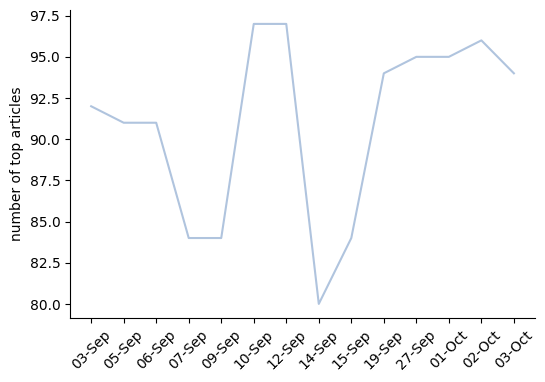

In [12]:
news['published_day_month'] = news['published_at'].dt.strftime("%d-%b")
top_articles = news.loc[news.top_article == 1]

plot_data = top_articles.copy()
plot_data['article_count'] = plot_data.groupby('published_day_month')['published_day_month'].transform('count')
plot_data = plot_data.loc[:, ['published_day_month', 'article_count']]
plot_data.drop_duplicates(inplace=True)

fig, ax = plt.subplots(figsize=(6,4))
ax = sns.lineplot(data = plot_data, x="published_day_month", y="article_count", color='lightsteelblue')
plt.xlabel(None)
plt.ylabel('number of top articles')
plt.xticks(rotation=45)
sns.despine()

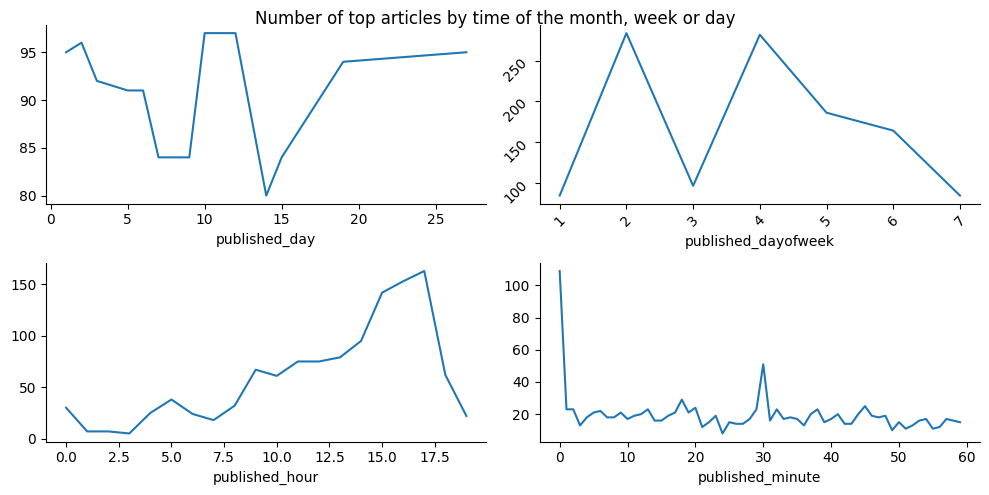

In [13]:
# exclude 3 October so we have just a whole month of data (and hence don't skew the results)
top_articles2 = top_articles[top_articles.published_day_month != "03-Oct"]
fig, ax = plt.subplots(2,2, figsize=(10,5))

data_day = pd.DataFrame(top_articles2.groupby('published_day')['published_day'].size())
sns.lineplot(data = data_day, x=data_day.index, y='published_day', ax = ax[0,0])
ax[0,0].set_ylabel(None)

data_dow = pd.DataFrame(top_articles2.groupby('published_dayofweek')['published_dayofweek'].size())
sns.lineplot(data = data_dow, x=data_dow.index, y='published_dayofweek', ax = ax[0,1])
ax[0,1].set_ylabel(None)
ax[0,1].tick_params(labelrotation=45)

data_hour = pd.DataFrame(top_articles2.groupby('published_hour')['published_hour'].size())
sns.lineplot(data = data_hour, x=data_hour.index, y='published_hour', ax = ax[1,0])
ax[1,0].set_ylabel(None)

data_minute = pd.DataFrame(top_articles2.groupby('published_minute')['published_minute'].size())
sns.lineplot(data = data_minute, x=data_minute.index, y='published_minute', ax = ax[1,1])
ax[1,1].set_ylabel(None)

sns.despine()
fig.tight_layout()
plt.subplots_adjust(top=0.95)
fig.suptitle("Number of top articles by time of the month, week or day");

The first plot indicated that most top articles were published on the 10th and 11th of September, and again on the 2nd of October. In addition, the second four plots indicated that top articles tended to be published:
- on the 10th or 11th day of the month, or at the very start or near the end
- on Tuesdays and Thursdays
- around 5pm in the evenings
- on the hour or half-way between.

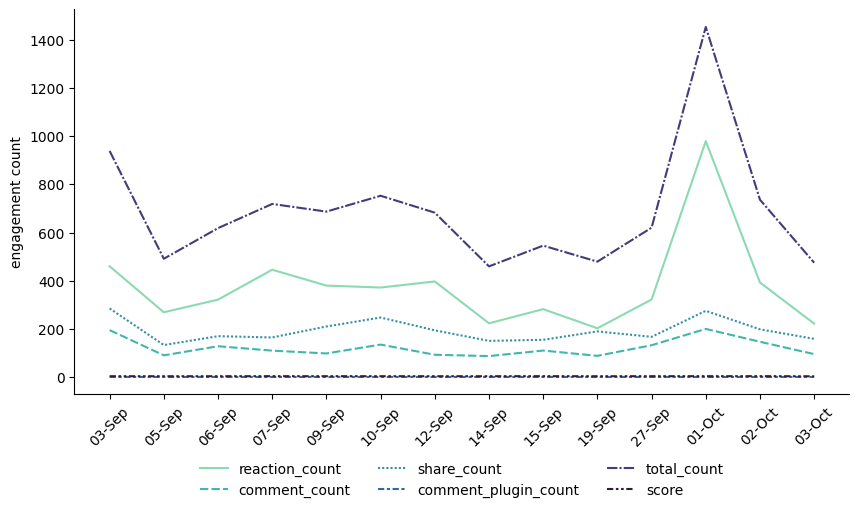

In [14]:
# time series of engagement
news['published_day_month'] = news['published_at'].dt.strftime("%d-%b")
news_cols = engagement_cols + ["published_day_month"]
news_sub = news[news_cols]
news_sub['id'] = news_sub.index

news_long = pd.melt(news_sub, id_vars = ['id', 'published_day_month'], var_name = 'metric', value_vars = engagement_cols)
news_long.metric = news_long.metric.str.replace("engagement_", "")

fig, ax = plt.subplots(figsize=(10,5))
palette = sns.color_palette("mako_r", 6)

ax = sns.lineplot(data = news_long, x="published_day_month", y="value", hue="metric", style="metric", palette=palette, ci=None)
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.3), ncol=3, frameon=False, title=None)
plt.xlabel(None)
plt.ylabel('engagement count')
plt.xticks(rotation=45)
sns.despine()

The plot above shows the aggregated level of engagement with articles over time. It indicates that the metrics tend to operate together, i.e. higher engagement on one metric tends to mean higher engagement on another, and that there was a spike in engagement on 1 October. A quick check of the correlation coefficients (see the plot below) largely confirmed this observation: changes in comment plugin engagement tended not to correlate well with any of the other metrics.

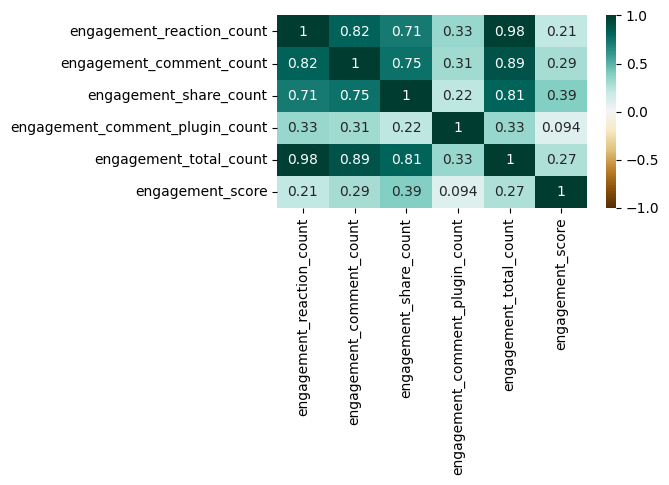

In [15]:
fig, ax = plt.subplots(figsize=(5,2.5))
sns.heatmap(news_sub[engagement_cols].corr(), vmin=-1, vmax=1, annot=True, cmap="BrBG");

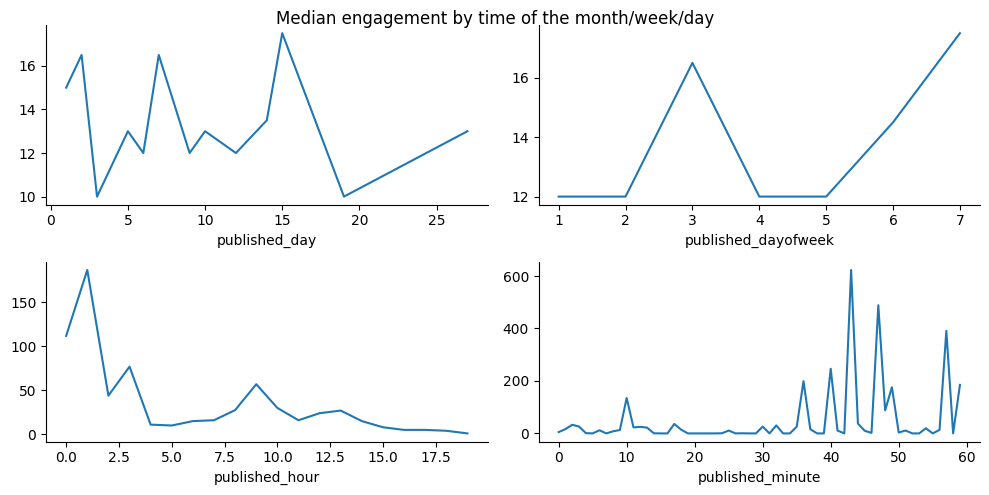

In [16]:
fig, ax = plt.subplots(2,2, figsize=(10,5))
published_cols = [col for col in news.columns if col.startswith("published_")]
news_sub = news.loc[news.published_day_month != "03-Oct", engagement_cols + published_cols]

data_day = pd.DataFrame(news_sub.groupby('published_day')['engagement_total_count'].median())
sns.lineplot(data = data_day, x='published_day', y='engagement_total_count', ax = ax[0,0])
ax[0,0].set_ylabel(None)

data_dow = pd.DataFrame(news_sub.groupby('published_dayofweek')['engagement_total_count'].median())
sns.lineplot(data = data_dow, x='published_dayofweek', y='engagement_total_count', ax = ax[0,1])
ax[0,1].set_ylabel(None)

data_hour = pd.DataFrame(news_sub.groupby('published_hour')['engagement_total_count'].median())
sns.lineplot(data = data_hour, x='published_hour', y='engagement_total_count', ax = ax[1,0])
ax[1,0].set_ylabel(None)

data_minute = pd.DataFrame(top_articles.groupby('published_minute')['engagement_total_count'].median())
sns.lineplot(data = data_minute, x='published_minute', y='engagement_total_count', ax = ax[1,1])
ax[1,1].set_ylabel(None)

sns.despine()
fig.tight_layout()
plt.subplots_adjust(top=0.95)
fig.suptitle("Median engagement by time of the month/week/day");

The plots above only consider total engagement. It was largely deemed sufficient considering that total engagement was closely correlated with the individual metrics. They indicated that average (median) engagement was highest when articles were published:
- on the 2nd, 7th or 15th day of the month
- on Wednesdays or Sundays
- just after midnight
- in the second-half of each hour, or at 10 minutes past the hour.

These periods have almost no overlap with the periods of the month/week/day of top articles, which provides further evidence that an author needs to choose which is more important (a top article status or high Facebook engagement).

## **Question 3: What are the most common words used in the titles and descriptions?**

In [8]:
# preprocess the text data
def preprocess_text(text, remove_num=False, remove_sw=False, sw_lst=None, lemm=True, stem=False, remove_single=True):
#     # convert to lowercase and strip out additional white space, then remove special characters
#     text = re.sub(r'[^\w\s]', '', str(text).lower().strip())

    # remove numbers
    if remove_num:
        text = re.sub(r'[\s\d+\s]', ' ', text)
        
#     # tokenise
#     text_lst = text.split()
   
    # convert strings to lowercase
    text = str(text).lower()
    
    # tokenise the strings
    tokeniser = RegexpTokenizer(r'\w+')
    tokenised_text = tokeniser.tokenize(text)
    
    # # remove numbers (but not words that contain numbers)
    # if remove_num:
    #     tokenised_text = [token for token in tokenised_text if not token.isnumeric()]
    
    # remove stopwords
    if remove_sw:
        tokenised_text = [token for token in tokenised_text if token not in sw_lst]
        
    # lemmatise (convert the word into root word)
    if lemm:
        lemmatiser = nltk.stem.wordnet.WordNetLemmatizer()
        tokenised_text = [lemmatiser.lemmatize(token) for token in tokenised_text]

    # stem (remove -ing, -ly, ...)
    if stem:
        stemmer = nltk.stem.porter.PorterStemmer()
        tokenised_text = [stemmer.stem(token) for token in tokenised_text]    

    # remove single-letter words
    if remove_single:
        tokenised_text = [token for token in tokenised_text if len(token) > 1]
    
    # join back together
    text = " ".join(tokenised_text)
    
    return text

# use the nltk stopwords list
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stopword_lst = nltk.corpus.stopwords.words("english")
# stopword_lst.extend(['says', 'say', 'said'])
# apply the preprocessing to the titles and descriptions
news['processed_title'] = news['title'].apply(lambda x: preprocess_text(
    x, remove_sw=True, sw_lst=stopword_lst, remove_single=True, stem=False, lemm=True))
news['processed_description'] = news['description'].apply(lambda x: preprocess_text(
    x, remove_sw=True, sw_lst=stopword_lst, remove_single=True, stem=False, lemm=True))

[nltk_data] Downloading package stopwords to /home/repl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/repl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/repl/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


/usr/local/lib/python3.8/dist-packages/wordcloud/wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

/usr/local/lib/python3.8/dist-packages/wordcloud/wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

/usr/local/lib/python3.8/dist-packages/wordcloud/wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

/usr/local/lib/python3.8/dist-packages/wordcloud/wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

/usr/local/lib/python3.8/dist-packages/wordcloud/wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

/usr/local/lib/python3.8/di

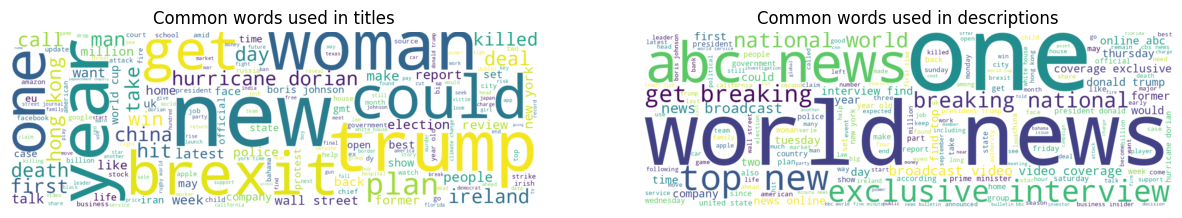

In [18]:
# identify the most common words used in titles and descriptions
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), facecolor=None)

wc = wordcloud.WordCloud(width=1500, height=500, background_color="white", min_font_size=10, repeat=True, stopwords=['says', 'say', 'said'])
wc.generate((" ".join(news.processed_title)))
ax1.axis("off")
ax1.imshow(wc, interpolation="bilinear")
ax1.set_title("Common words used in titles")

wc = wordcloud.WordCloud(width=1500, height=500, background_color="white", min_font_size=10, repeat=True, stopwords=['says', 'say', 'said'])
wc.generate((" ".join(news.processed_description)))
ax2.axis("off")
ax2.imshow(wc, interpolation="bilinear")
ax2.set_title("Common words used in descriptions");

/usr/local/lib/python3.8/dist-packages/wordcloud/wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

/usr/local/lib/python3.8/dist-packages/wordcloud/wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

/usr/local/lib/python3.8/dist-packages/wordcloud/wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

/usr/local/lib/python3.8/dist-packages/wordcloud/wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

/usr/local/lib/python3.8/dist-packages/wordcloud/wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

/usr/local/lib/python3.8/di

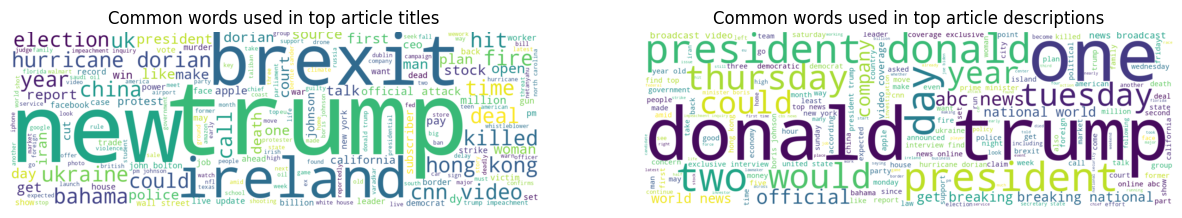

In [19]:
# what about top articles?
top_articles = news.loc[news.top_article == 1, :]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), facecolor=None)

wc = wordcloud.WordCloud(width=1500, height=500, background_color="white", min_font_size=10, repeat=True, stopwords=['says', 'say', 'said'])
wc.generate((" ".join(top_articles.processed_title)))
ax1.axis("off")
ax1.imshow(wc, interpolation="bilinear")
ax1.set_title("Common words used in top article titles")

wc = wordcloud.WordCloud(width=1500, height=500, background_color="white", min_font_size=10, repeat=True, stopwords=['says', 'say', 'said'])
wc.generate((" ".join(top_articles.processed_description)))
ax2.axis("off")
ax2.imshow(wc, interpolation="bilinear")
ax2.set_title("Common words used in top article descriptions");

/usr/local/lib/python3.8/dist-packages/wordcloud/wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

/usr/local/lib/python3.8/dist-packages/wordcloud/wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

/usr/local/lib/python3.8/dist-packages/wordcloud/wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

/usr/local/lib/python3.8/dist-packages/wordcloud/wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

/usr/local/lib/python3.8/dist-packages/wordcloud/wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

/usr/local/lib/python3.8/di

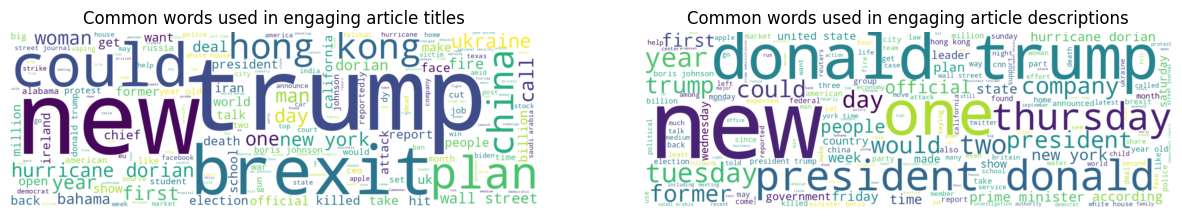

In [20]:
# and finally, what about articles with high engagement?
median_engagement = news.engagement_total_count.median()
quantile_engagement = news.engagement_total_count.quantile(0.75)

engaging_articles = news.loc[news.engagement_total_count >= quantile_engagement]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), facecolor=None)

wc = wordcloud.WordCloud(width=1500, height=500, background_color="white", min_font_size=10, repeat=True, stopwords=['says', 'say', 'said'])
wc.generate((" ".join(engaging_articles.processed_title)))
ax1.axis("off")
ax1.imshow(wc, interpolation="bilinear")
ax1.set_title("Common words used in engaging article titles")

wc = wordcloud.WordCloud(width=1500, height=500, background_color="white", min_font_size=10, repeat=True, stopwords=['says', 'say', 'said'])
wc.generate((" ".join(engaging_articles.processed_description)))
ax2.axis("off")
ax2.imshow(wc, interpolation="bilinear")
ax2.set_title("Common words used in engaging article descriptions");

The word clouds for the titles and descriptions of all articles, only top articles and engaging articles (those with total engagement in the top 25% percentile) have some common themes. Top articles focussed on Trump, Hurricane Dorian and Brexit, and so did articles with high engagement. Engaging articles also referenced Asia (Hong Kong and China) a lot.

## Question 4: What is the overall sentiment of articles?

In [21]:
news["title_sentiment"] = news.dropna(subset='title')['title'].apply(lambda x: TextBlob(x).sentiment.polarity)
news["description_sentiment"] = news.dropna(subset='description')['description'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [22]:
news[['title_sentiment', 'description_sentiment']].describe()

title_sentiment  description_sentiment
count     10433.000000           10411.000000
mean          0.034374               0.082248
std           0.229587               0.225751
min          -1.000000              -1.000000
25%           0.000000               0.000000
50%           0.000000               0.000000
75%           0.062500               0.193119
max           1.000000               1.000000

In [23]:
top_articles = news.loc[news.top_article == 1]
top_articles[['title_sentiment', 'description_sentiment']].describe()

title_sentiment  description_sentiment
count      1273.000000            1271.000000
mean          0.016814               0.066727
std           0.217059               0.223500
min          -1.000000              -0.700000
25%           0.000000               0.000000
50%           0.000000               0.000000
75%           0.033333               0.175000
max           1.000000               1.000000

In [24]:
engaging_articles = news.loc[news.engagement_total_count >= quantile_engagement]
engaging_articles[['title_sentiment', 'description_sentiment']].describe()

title_sentiment  description_sentiment
count      2608.000000            2608.000000
mean          0.027181               0.060496
std           0.225263               0.209351
min          -1.000000              -1.000000
25%           0.000000               0.000000
50%           0.000000               0.000000
75%           0.050000               0.158333
max           1.000000               1.000000

All three tables above indicate that the overall sentiment of the titles and descriptions is actually neutral, irrespective of what the word clouds might have suggested.

## Question 5: Are there any strong correlations between user engagement and/or top article status and other features in the dataset?

In [9]:
# now consider titles and descriptions text as a single feature
news['title_description'] = news['title'] + ' ' + news['description']
news['processed_title_description'] = news['processed_title'] + ' ' + news['processed_description']

In [26]:
# add overall sentiment
news["sentiment"] = news.dropna(subset='title_description')['title_description'].apply(lambda x: TextBlob(x).sentiment.polarity)

# add word, character and sentence lengths
news['num_words'] = news['title_description'].apply(lambda x: len(str(x).split(" ")))
news['num_chars'] = news['title_description'].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
news['num_sentences'] = news['title_description'].apply(lambda x: len(str(x).split(".")))
news['avg_word_length'] = news['num_chars'] / news['num_words']
news['avg_sentence_length'] = news['num_words'] / news['num_sentences']

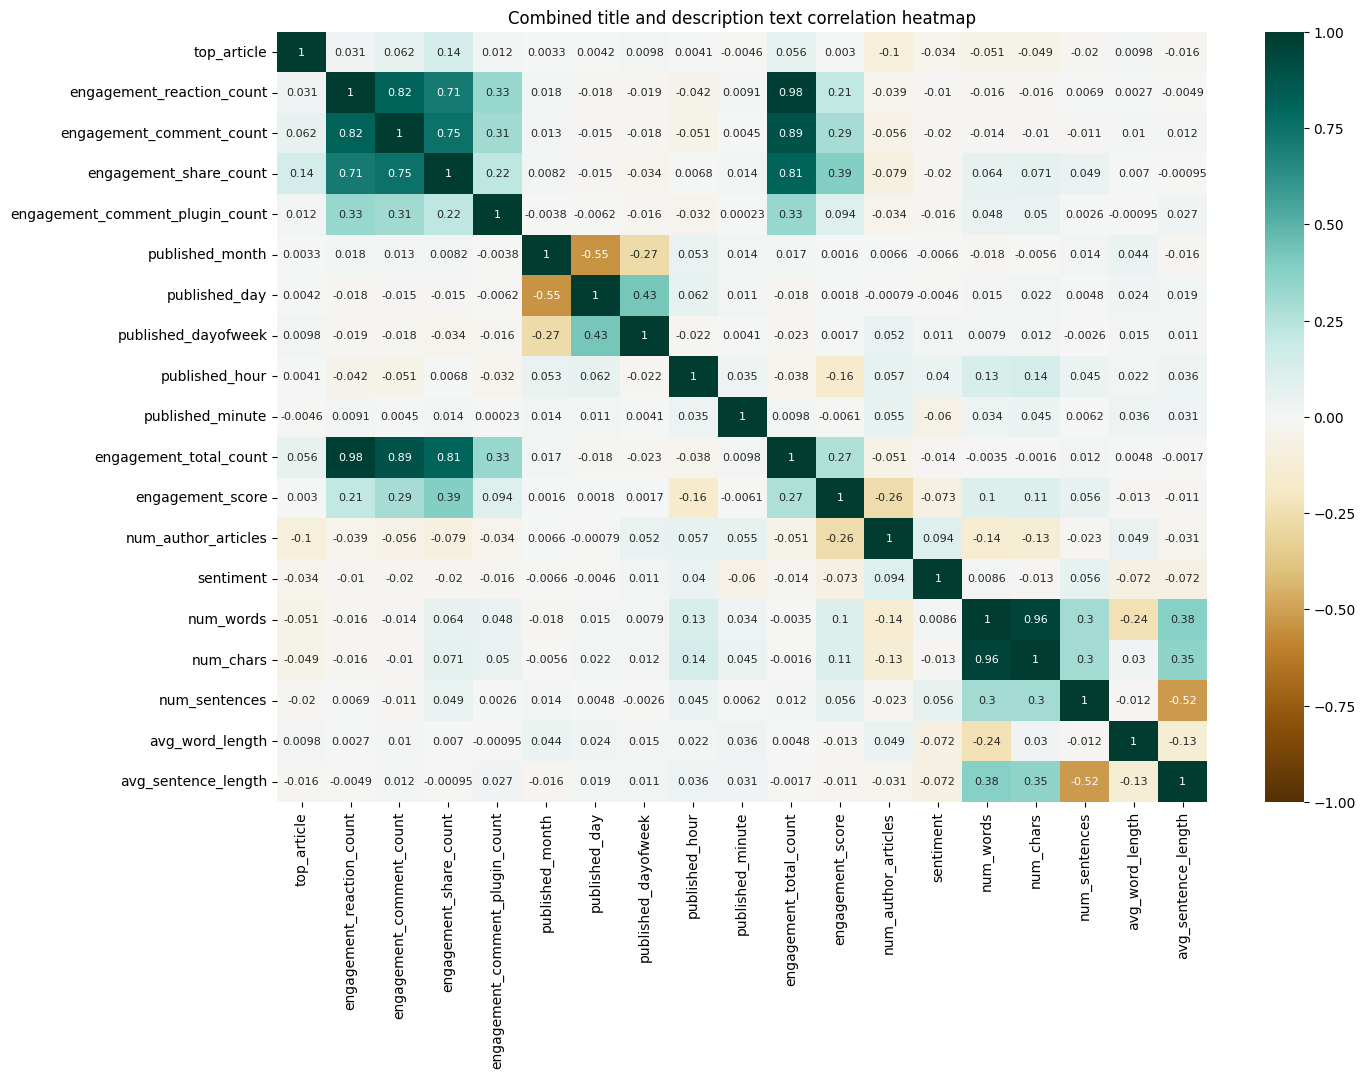

In [27]:
fig, ax = plt.subplots(figsize=(15,10))
corrplot = sns.heatmap(news.drop(columns=['title_sentiment', 'description_sentiment']).corr(), vmin=-1, vmax=1, annot=True, cmap="BrBG", annot_kws={"fontsize":8})
corrplot.set_title('Combined title and description text correlation heatmap')  
plt.show()

The primary takeaway from the heatmap is that top article status and user engagement has very little to do with the basic characteristics of the articles (word counts, length, sentiment, etc) and instead must depend on the content of the article itself. That being said, top article status seems to have a very slightly stronger positive relationship with how much the article is shared and a slightly stronger negative relationship with how many articles the author has published. The engagement score (recall that it is the log(x+1) of engagement_total_count) is negatively correlated with the publication hour, the number of articles published by the author and slightly positively correlated with the number of words/characters in the text.

## Question 6: Are there any themes on 3 September or 1 October, when engagement was higher than usual?

In [10]:
# load the spacy language model (only required once per session)
ner = spacy.load("en_core_web_lg")

In [11]:
# drop any rows with no text
news_sub = news.dropna(subset='title_description')

# use Spacy to identify named entities, modify the title_description text and preprocess it again
news_sub['entities'] = news_sub['title_description'].apply(lambda x: ner(x).ents)

def replace_text(input_text, entities):
    for entity in entities:
        try:
            input_text = re.sub(entity.text, "_".join(entity.text.split()), input_text)
        except:
            # don't want to spend the time fixing this so just ignoring it
            pass
    
    return input_text

news_sub['new_title_description'] = news_sub.apply(lambda x: replace_text(x['title_description'], x['entities']), axis=1)
news_sub['processed_new_title_description'] = news_sub['new_title_description'].apply(lambda x: preprocess_text(
    x, remove_sw=True, sw_lst=stopword_lst, stem=False, lemm=True))

In [30]:
# filter to only include 3 September and 1 October
cols = [col for col in news_sub.columns if col.endswith('_description') or col == 'sentiment']
news_sept = news_sub.loc[(news_sub.published_month == 9) & (news_sub.published_day == 3), cols]
news_oct = news_sub.loc[(news_sub.published_month == 10) & (news_sub.published_day == 1), cols]

The results below indicate that 809 and 753 articles were released on 3 September 1 October respectively, and average (mean and median) sentiment was slightly positive on both days.

In [31]:
# check what the sentiment was like on both days
print(news_sept.sentiment.describe())
print('\n')
print(news_oct.sentiment.describe())

count    809.000000
mean       0.080010
std        0.217833
min       -1.000000
25%       -0.025000
50%        0.040179
75%        0.187500
max        1.000000
Name: sentiment, dtype: float64


count    753.000000
mean       0.059676
std        0.224609
min       -1.000000
25%       -0.041667
50%        0.025000
75%        0.175000
max        0.866667
Name: sentiment, dtype: float64


/usr/local/lib/python3.8/dist-packages/wordcloud/wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

/usr/local/lib/python3.8/dist-packages/wordcloud/wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

/usr/local/lib/python3.8/dist-packages/wordcloud/wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

/usr/local/lib/python3.8/dist-packages/wordcloud/wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

/usr/local/lib/python3.8/dist-packages/wordcloud/wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

/usr/local/lib/python3.8/di

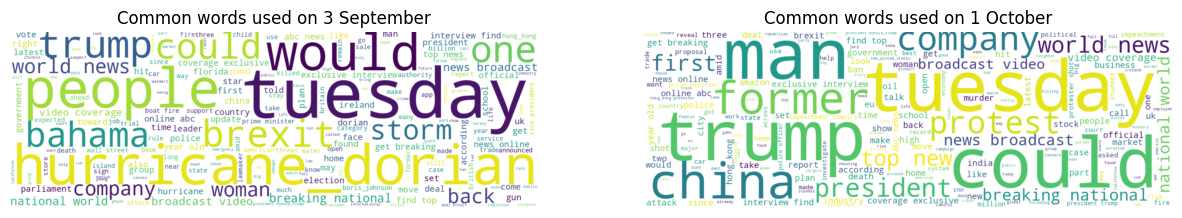

In [32]:
# identify the most common words used on those dates
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), facecolor=None)

wc = wordcloud.WordCloud(width=1500, height=500, background_color="white", min_font_size=10, repeat=True, stopwords=['says', 'say', 'said'])
wc.generate((" ".join(news_sept.processed_new_title_description)))
ax1.axis("off")
ax1.imshow(wc, interpolation="bilinear")
ax1.set_title("Common words used on 3 September")

wc = wordcloud.WordCloud(width=1500, height=500, background_color="white", min_font_size=10, repeat=True, stopwords=['says', 'say', 'said'])
wc.generate((" ".join(news_oct.processed_new_title_description)))
ax2.axis("off")
ax2.imshow(wc, interpolation="bilinear")
ax2.set_title("Common words used on 1 October");

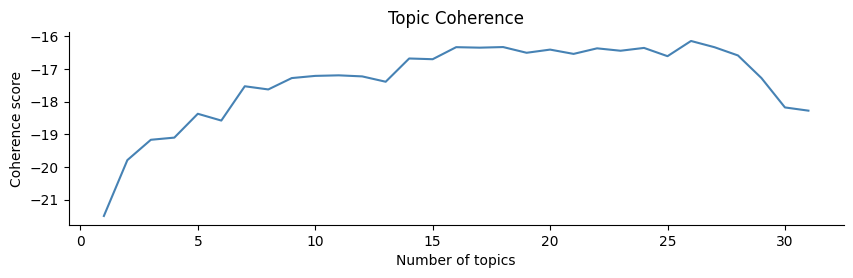

In [33]:
def generate_model_input(processed_text):
    corpus = processed_text
    tokenised_corpus = [string.split() for string in corpus]

    # bigram = gensim_models.Phrases(tokenised_corpus, min_count=20)
    # for idx in range(len(tokenised_corpus)):
    #     for token in bigram[tokenised_corpus[idx]]:
    #         if '_' in token:
    #             tokenised_corpus[idx].append(token)
    
    # pre-process the texts/corpus into lists of bigrams
    ngram_length = 2
    new_tokenised_corpus = []
    for doc in tokenised_corpus:
        ngrams_lst = [" ".join(doc[i:i + ngram_length]) for i in range(0, len(doc), ngram_length)]
        new_tokenised_corpus.append(ngrams_lst)

    # create a dictionary representation of the articles
    dictionary = gensim.corpora.Dictionary(new_tokenised_corpus)

    # transform the articles into a vectorised form i.e. compute the frequency of each term
    # BoW representation of the articles
    bow_corpus = [dictionary.doc2bow(doc) for doc in new_tokenised_corpus]

    # make an index to word dictionary
    temp = dictionary[0]
    id2word = dictionary.id2token
    
    return bow_corpus, dictionary, id2word, new_tokenised_corpus

def generate_topics(bow_corpus, id2word, num_topics):
    # note that it doesn't actually matter whether id2word is dictionary.id2token or dictionary
    
    # set training parameters
    num_topics = num_topics
    eval_every = None # high computational cost if want to evaluate model perplexity

    lda_model = gensim_models.ldamodel.LdaModel(corpus=bow_corpus,
                                                id2word=id2word,
                                                num_topics=num_topics,
                                                update_every=1,
                                                chunksize=100,
                                                passes=20,
                                                iterations=400,
                                                alpha='auto',
                                                eta='auto',
                                                eval_every=eval_every,
                                                per_word_topics=True)
    
    # get the output
    dict_lsts = []
    for i in range(0, num_topics):
        tuples_lst = lda_model.get_topic_terms(i)
        for tuple in tuples_lst:
            dict_lsts.append({"topic": i,
                              "id": tuple[0],
                              "ngram": id2word[tuple[0]],
                              "weight": tuple[1]})
    topics_df = pd.DataFrame(dict_lsts, columns=['topic', 'id', 'ngram', 'weight'])

    return topics_df, lda_model, num_topics

processed_text = news_oct.processed_new_title_description
# generate the model input
bow_corpus, dictionary, id2word, tokenised_corpus = generate_model_input(processed_text)
# train the model and analyse topic coherence
coherence_lst = []
for i in range(1, 32, 1):
    # recall '_' means we don't care about that function output
    _, lda_model, _ = generate_topics(bow_corpus, id2word, num_topics=i)
    top_topics = lda_model.top_topics(corpus=bow_corpus, topn=50, coherence='u_mass')
    # top_topics = lda_model.top_topics(corpus=bow_corpus, texts=tokenised_corpus, dictionary=dictionary, coherence='c_v', topn=50)
    avg_coherence = sum([t[1] for t in top_topics]) / i
    coherence_lst.append((i, avg_coherence))
coherence_df = pd.DataFrame(coherence_lst, columns=["topics", "coherence"])

fig, ax = plt.subplots(figsize=(10, 2.5))
sns.lineplot(coherence_df, x="topics", y="coherence", color='steelblue')
ax.set_title("Topic Coherence")
ax.set_xlabel("Number of topics")
ax.set_ylabel("Coherence score")
sns.despine();

In [34]:
# locate the highest coherence score
idx = np.argmax(coherence_df['coherence'])
best_num = coherence_df.iloc[idx]['topics'].astype(int)
num_topics = 12

# re-train the model
bow_corpus, dictionary, id2word, tokenised_corpus = generate_model_input(processed_text)
topics_df, lda_model, num_topics = generate_topics(bow_corpus, id2word, num_topics=num_topics)

# compute how many tokens are documents were being trained on
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(bow_corpus))
print('Number of topics: %d' % num_topics)

Number of unique tokens: 7106
Number of documents: 753
Number of topics: 12


In [35]:
pyLDAvis.enable_notebook()
news_data = gensimvis.prepare(topic_model=lda_model, dictionary=dictionary, corpus=bow_corpus, mds='mmds')
news_data
# mmds = Metric Multidimensional Scaling
# pcoa = Principal Coordinate Analysis
# tsne = t-distributed Stochastic Neighbor Embedding

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.135443 -0.153020       1        1  15.948879
6     -0.059290 -0.191630       2        1  14.661998
10    -0.176779 -0.025567       3        1  11.992907
3     -0.080616  0.156710       4        1  11.716029
11     0.151039  0.017238       5        1   8.736476
1      0.055773  0.001205       6        1   6.865060
0      0.001010  0.084204       7        1   6.247875
9     -0.033850 -0.036543       8        1   6.196439
4     -0.059164  0.031948       9        1   5.834149
8      0.067946  0.092726      10        1   5.310801
5      0.004078  0.018417      11        1   3.879357
2     -0.005592  0.004313      12        1   2.610031, topic_info=                     Term       Freq      Total Category  logprob  loglift
172        video coverage  14.000000  14.000000  Default  30.0000  30.0000
168        national world  14.000000  14.000000  Default  29.0000  29.0000
162              abc news  14.000000  14.000000  Default  28.0000  28.0000
165   exclusive interview  14.000000  14.000000  Default  27.0000  27.0000
166              find top  14.000000  14.000000  Default  26.0000  26.0000
...                   ...        ...        ...      ...      ...      ...
2750       total decrease   0.237665   0.911179  Topic12  -6.8386   2.3019
594                60 cut   0.165313   0.838827  Topic12  -7.2016   2.0216
595                 85 60   0.165313   0.838827  Topic12  -7.2016   2.0216
596             brexit 85   0.165313   0.838827  Topic12  -7.2016   2.0216
597          brexit delay   0.165313   0.838827  Topic12  -7.2016   2.0216

[390 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
6970      3  0.847004      000 traveler
4183      8  0.482188       120 billion
4784      6  0.844849           15 year
3737      2  0.745564              2019
2065      8  0.609873             30 19
...     ...       ...               ...
6199      8  0.609948      year journey
1432      2  0.976719          year low
617       6  0.961544          year old
4795      6  0.495396  year old_sibling
1682      8  0.509069         york time

[330 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 7, 11, 4, 12, 2, 1, 10, 5, 9, 6, 3])

In [36]:
# identify the dominant topic in each article
sent_topics_df = pd.DataFrame()

for i, row_list in enumerate(lda_model[bow_corpus]):
    row = row_list[0] if lda_model.per_word_topics else row_list
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    # get the dominant topic, perc contribution and keywords for each article
    for j, (topic_num, prop_topic) in enumerate(row):
        if j == 0:  # => dominant topic
            wp = lda_model.show_topic(topic_num, topn=20)
            topic_keywords = ", ".join([word for word, prop in wp])
            sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
        else:
            break
sent_topics_df.columns = ['dominant_topic', 'perc_contribution', 'topic_keywords']

# add original text to the end of the output
contents = pd.DataFrame(news_oct.new_title_description).reset_index(drop=True)
dominant_topic_df = sent_topics_df.copy()
dominant_topic_df['title_description'] = contents
dominant_topic_df.reset_index(inplace=True)
dominant_topic_df.columns = ['article_no', 'dominant_topic', 'topic_perc_contrib', 'topic_keywords', 'text']
dominant_topic_df

article_no  ...                                               text
0             0  ...  As ocean fears gather pace, WTO fishing talks ...
1             1  ...  Lawmakers plan investigation in NJ_Transit's '...
2             2  ...  U.S. government watchdog faults DEA for slow r...
3             3  ...  The Golden State Killer After 40_years, police...
4             4  ...  Apple and Google push to transform video game ...
..          ...  ...                                                ...
748         748  ...  Africa's tallest building is set to open, and ...
749         749  ...  Mark_Zuckerberg said an Elizabeth_Warren presi...
750         750  ...  Pompeo_Objects_to_Deposition_Dates for State_D...
751         751  ...  WSJ Wealth Adviser Briefing: Convertible Secur...
752         752  ...  Charles_Schwab says it will cut online stock a...

[753 rows x 5 columns]

In [37]:
print(dominant_topic_df.loc[4, "topic_keywords"])
print('-----')
print(dominant_topic_df.loc[4, "text"])

found guilty, guilty murder, new york, away earth, time new, ex cop, video game, 120 billion, secretary state, murder, york time, head coach, democrat subpoena, 30 19, year doping, ukraine call, nasa via, animation planetary, donoghue show, moon billion
-----
Apple and Google push to transform video game industry With Apple_Arcade and Stadia, Apple and Google are looking to take a bigger role in the gaming industry, and they picked the perfect time.


In [38]:
# identify the volume and distribution of topics
# number and proportion of articles in each topic
topic_counts = dominant_topic_df['dominant_topic'].value_counts()
topic_prop = round(topic_counts / topic_counts.sum(), 4)

# topic number and keywords
topic_num_keywords = dominant_topic_df[['dominant_topic', 'topic_keywords']]

In [39]:
model_topics = lda_model.show_topics(formatted=True, num_words=15, num_topics=20) # set to false for pprint
model_topics
# pprint(final_lda_model.print_topics(num_words=10))

[(0,
  '0.008*"wsj com" + 0.005*"seven year" + 0.005*"america middle" + 0.005*"auto loan" + 0.005*"class afford" + 0.004*"car seven" + 0.004*"afford car" + 0.004*"middle class" + 0.004*"year auto" + 0.004*"loan america" + 0.004*"los_angeles lease" + 0.004*"store_plan_moves_ahead los_angeles" + 0.004*"amazon grocery" + 0.004*"lease amazon" + 0.004*"grocery store_plan_moves_ahead"'),
 (1,
  '0.017*"year old" + 0.005*"killed protecting" + 0.004*"stereotype boy" + 0.004*"play truck" + 0.004*"beloved baby" + 0.004*"boy photoshoot" + 0.004*"girl play" + 0.004*"sister intruder" + 0.003*"florida teenager" + 0.003*"15 year" + 0.002*"police say" + 0.002*"year old_sibling" + 0.002*"break sister" + 0.002*"keeper newsweek" + 0.002*"official say"'),
 (2,
  '0.010*"pain nationwide" + 0.010*"midwest faltering" + 0.010*"economy spread" + 0.006*"4th story" + 0.005*"third column" + 0.002*"jpmorgan say" + 0.002*"25 million" + 0.001*"jpmorgan" + 0.001*"brexit political" + 0.001*"recession moment" + 0.001*"

Note that the visualisation and output topics are not in the same order. Inferred topics from the keywords are:
- economic upheaval ('Tuesday') 6
- military and defence ('defence system') 7
- politics - protests ('video coverage') 2
- government ('impeachment') 4
- politics - asia ('hong_kong protester') 5
- politics - brexit ('custom check') 1
- domestic issues ('amazon') 3
- politics ('state mike_pompeo') 8
- violence ('killed') 9
- stockmarket / finance ('announced Tuesday') 10

## Question 7: Can a model be developed to accurately predict top article status?

In [12]:
cols = ['title', 'description', 'top_article', 'engagement_score', 'title_description', 'new_title_description']

news_data = news_sub[cols]
# process the data
news_data['processed_title_description'] = news_data['title_description'].apply(lambda x: preprocess_text(
    x, remove_sw=True, sw_lst=stopword_lst, remove_single=False, stem=False, lemm=True))
news_data['processed_new_title_description'] = news_data['new_title_description'].apply(lambda x: preprocess_text(
    x, remove_sw=True, sw_lst=stopword_lst, remove_single=False, stem=False, lemm=True))

In [13]:
# split the dataset into two
train_data, test_data = model_selection.train_test_split(news_sub, test_size=0.2, stratify=news_sub.top_article, random_state=23)
y_train = train_data['top_article'].values
y_test = test_data['top_article'].values

### Bag-of-Words (BoW) Model

In [14]:
feature_col = 'processed_title_description'

# define the pipeline
pipeline = make_pipeline(
    # create a vectoriser
    # extract unigrams and bigrams
    # tfidf is a more advanced count vectoriser taking into account how frequently words appear across documents
    feature_extraction.text.TfidfVectorizer(ngram_range=(1,2), sublinear_tf=True),
    # create a re-sampler
    RepeatedEditedNearestNeighbours(),
    # create a grid search object
    model_selection.GridSearchCV(
        # name the algorithm
        naive_bayes.MultinomialNB(),
        # define the hyperparameter grid
        param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
        cv=5,
        scoring='roc_auc'
    )
)

# fit the pipeline on the training data
pipeline.fit(train_data[feature_col], y_train)

# make predictions on the test data
pred_probs = pipeline.predict_proba(test_data[feature_col])[:, 1]
preds = pipeline.predict(test_data[feature_col])

Accuracy: 0.68
AUC: 0.61
Detail:
              precision    recall  f1-score   support

         0.0       0.91      0.71      0.80      1828
         1.0       0.18      0.47      0.27       254

    accuracy                           0.68      2082
   macro avg       0.55      0.59      0.53      2082
weighted avg       0.82      0.68      0.73      2082



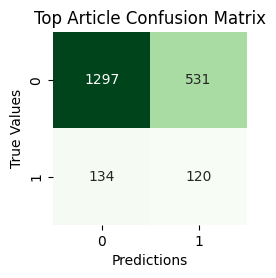

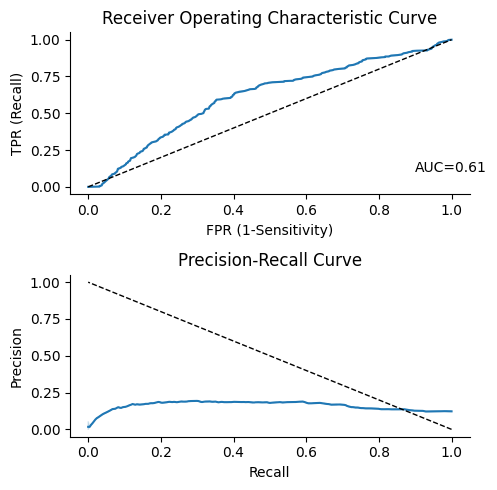

In [15]:
# evaluate model performance
accuracy = smetrics.accuracy_score(y_test, preds)
auc = smetrics.roc_auc_score(y_test, pred_probs)
print("Accuracy:", round(accuracy, 2))
print("AUC:", round(auc, 2))
print("Detail:")
print(smetrics.classification_report(y_test, preds))

cm = smetrics.confusion_matrix(y_test, preds)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Greens, cbar=False)
plt.xlabel("Predictions")
plt.ylabel("True Values")
plt.title("Top Article Confusion Matrix")

fig, ax = plt.subplots(figsize=(5, 5), nrows=2, ncols=1)
## Plot roc
fpr, tpr, thresholds = smetrics.roc_curve(y_test, pred_probs)
sns.lineplot(x=fpr, y=tpr, ax=ax[0])
ax[0].text(x=0.9, y=0.1, s='AUC={0:0.2f}'.format(auc))
ax[0].plot([0,1], [0,1], color='black', linestyle='--', lw=1)
ax[0].set(xlabel="FPR (1-Sensitivity)",
          ylabel="TPR (Recall)",
          title="Receiver Operating Characteristic Curve")
    
## Plot precision-recall curve
precision, recall, thresholds = smetrics.precision_recall_curve(y_test, pred_probs)
sns.lineplot(x=recall, y=precision, ax=ax[1])
# ax[1].text(x=0.9, y=0.1, s='AUC={0:0.2f}'.format(auc))
ax[1].plot([1,0], [0,1], color='black', linestyle='--', lw=1)
ax[1].set(xlabel="Recall",
          ylabel="Precision",
          title="Precision-Recall Curve")
fig.tight_layout()
sns.despine()

Ok, so this model isn't great for identifying top articles. Let's see if a word embeddings approach can do better.

### Word Embedding Model (from scratch)

In [16]:
corpus = train_data[feature_col]

# split the text into tokens
tokenised_corpus = []
for string in corpus:
    tokens = string.split()
    unigrams = [" ".join(tokens[i:i+1]) for i in range(0, len(tokens), 1)]
    tokenised_corpus.append(unigrams)

# detect bigrams and trigrams
bigrams_detector = gensim_models.Phrases(tokenised_corpus, delimiter="_")
bigrams_detector = gensim_models.phrases.Phraser(bigrams_detector)

trigrams_detector = gensim_models.Phrases(bigrams_detector[tokenised_corpus], delimiter="_")
trigrams_detector = gensim_models.phrases.Phraser(trigrams_detector)

# add the ngrams to the corpus
for idx in range(len(tokenised_corpus)):
    for token in trigrams_detector[tokenised_corpus[idx]]:
        if '_' in token:
            tokenised_corpus[idx].append(token)

# convert the list of lists of ngrams back into a pandas series
tokenised_df = pd.DataFrame({'ngrams': tokenised_corpus})
tokenised_df['text'] = tokenised_df['ngrams'].apply(lambda x: " ".join(x))
new_corpus = tokenised_df.text

# split the text strings into tokens
tokeniser = kprocessing.text.Tokenizer(split=' ', oov_token="NaN")
# construct the word index
tokeniser.fit_on_texts(new_corpus)
token_index = tokeniser.word_index
total_tokens = len(token_index)+1 #+1 for padding (need this for the model)

# convert the text data to sequences (integer lists)
train_sequences = tokeniser.texts_to_sequences(new_corpus)

# check the length of the sequences
# we need to pad them so they're all of the same length, but don't want to unecessarily pad short ones
# or cut short too many long ones
lengths = ([len(seq) for seq in train_sequences])
maxlen = np.max(lengths)
qlen = np.quantile(lengths, 0.75)
# this rounds maxlen or qlen up to the nearest 10
padlen = int(math.ceil(qlen / 10.0)) * 10

# pad the sequences to 2D integer tensors of the same length
X_train = kprocessing.sequence.pad_sequences(train_sequences, maxlen=padlen)

# resample the training data
y_train = train_data['top_article'].values
X_train_rs, y_train_rs = RepeatedEditedNearestNeighbours().fit_resample(X_train, y_train)

In [17]:
# repeat the pre-processing for the test data
corpus = test_data[feature_col]

# split the text into tokens
tokenised_corpus = []
for string in corpus:
    tokens = string.split()
    unigrams = [" ".join(tokens[i:i+1]) for i in range(0, len(tokens), 1)]
    tokenised_corpus.append(unigrams)

# detect common bigrams and trigrams using the fitted detectors
tokenised_corpus = list(bigrams_detector[tokenised_corpus])
tokenised_corpus = list(trigrams_detector[tokenised_corpus])

# convert the list of lists of ngrams back into a pandas series
tokenised_df = pd.DataFrame({'ngrams': tokenised_corpus})
tokenised_df['text'] = tokenised_df['ngrams'].apply(lambda x: " ".join(x))
new_corpus = tokenised_df.text

# convert the text to sequences and pad
test_sequences = tokeniser.texts_to_sequences(new_corpus)
X_test = kprocessing.sequence.pad_sequences(test_sequences, maxlen=padlen)
y_test = test_data['top_article'].values

# recall that we don't resample the test data

In [18]:
class Attention(layers.Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(Attention,self).__init__()
        
    def build(self, input_shape):
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1), initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1), initializer="zeros")
        super(Attention,self).build(input_shape)
        
    def call(self, x):
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

In [20]:
# define the model architecture
METRICS = [
    kmetrics.AUC(name='auc'),
    kmetrics.AUC(name='prc', curve='PR'),
    kmetrics.BinaryAccuracy(name='accuracy')
]

# fix the bias
classes, counts = np.unique(y_train, return_counts=True)
initial_bias = np.log([counts[1]/counts[0]])
output_bias = initializers.Constant(initial_bias)

# input layer
x_in = layers.Input(shape=(padlen,))
# embedding layer
# input dim: vocab_size + 1
# outut dim: dimension of the dense embedding
x = layers.Embedding(input_dim=total_tokens, output_dim=200, input_length=padlen, trainable=True)(x_in)
# attention layer
x = Attention(return_sequences=True)(x)
# bidirectional lstm layers
x = layers.Bidirectional(layers.LSTM(15, dropout=0.2, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(15, dropout=0.2))(x)
# dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)(x)

# calculate class weights
classes, counts = np.unique(y_train, return_counts=True)
total = counts[0] + counts[1]
weight_for_0 = (1 / counts[0]) * (total / 2.0)
weight_for_1 = (1 / counts[1]) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

# compile model
model = models.Model(x_in, y_out)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)

model.summary()

# add a callback
es = callbacks.EarlyStopping(monitor='val_prc', mode='max', verbose=1, patience=5)

# fit the model to the training data
history = model.fit(X_train, y_train, batch_size=128, epochs=20, validation_split=0.2, verbose=1, callbacks=[es], class_weight=class_weight)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 40)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 40, 200)           3881600   
                                                                 
 attention_1 (Attention)     (None, 40, 200)           240       
                                                                 
 bidirectional_2 (Bidirectio  (None, 40, 30)           25920     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 30)               5520      
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 64)                1984  

In [21]:
# build a Conv1D, Bi-directional RNN, LSTMs and GRU model

## input
# input sequence
x_in = layers.Input(shape=(padlen,))
## embedding layer
# inputs are the sequences and embedding matrix defined previously
# outputs are a 2D matrix with a word vector for each word id in the input sequence (sequence_length (max_len) * vector size)
x = layers.Embedding(input_dim=total_tokens, output_dim=200, input_length=padlen, trainable=True)(x_in)
## layers of bidirectional lstm
# model the order of the words in both directions
x = layers.Bidirectional(layers.LSTM(units=64, dropout=0.1, recurrent_dropout=0.1, activation='tanh', return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=64, dropout=0.2, recurrent_dropout=0.2, activation='tanh', return_sequences=True))(x)
x = layers.Bidirectional(layers.SimpleRNN(units=64, dropout=0.2, recurrent_dropout=0.2, activation='tanh', return_sequences=True))(x)
## convolutional layer
x = layers.Conv1D(72, 3, activation='tanh')(x)
x = layers.MaxPooling1D(2)(x)
x = layers.SimpleRNN(64, activation='tanh', dropout=0.2, recurrent_dropout=0.20, return_sequences=True)(x)
# GRU layer
x = layers.GRU(64, recurrent_dropout=0.20, recurrent_regularizer='l1_l2')(x)
## final dense layers
# to predict the probability of whether the article will be a top article or not
x = layers.Dropout(0.2)(x)
y_out = layers.Dense(1, activation='sigmoid')(x)

# compile model
model = models.Model(x_in, y_out)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)

model.summary()

# add a callback
es = callbacks.EarlyStopping(monitor='val_prc', mode='max', verbose=1, patience=5)  

# fit the model to the training data
history = model.fit(X_train, y_train, batch_size=128, epochs=20, validation_split=0.2, verbose=1, callbacks=[es], class_weight=class_weight)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 40)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 40, 200)           3881600   
                                                                 
 bidirectional_4 (Bidirectio  (None, 40, 128)          135680    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 40, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_6 (Bidirectio  (None, 40, 128)          24704     
 nal)                                                            
                                                           

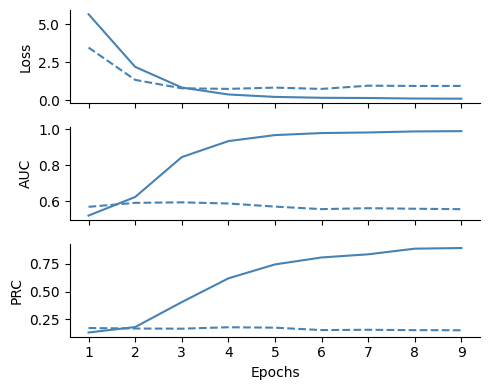

In [22]:
metrics = [k for k in history.history.keys() if ("loss" not in k) and ("val" not in k)]

fig, ax = plt.subplots(figsize=(5, 4), nrows=3, ncols=1, sharex=True)
# plot loss
sns.lineplot(x=[i+1 for i in range(len(history.history['loss']))], y=history.history['loss'], ax=ax[0], color='steelblue')
sns.lineplot(x=[i+1 for i in range(len(history.history['val_loss']))], y=history.history['val_loss'], ax=ax[0], color='steelblue',
             linestyle='dashed')
ax[0].set(xlabel="Epochs", ylabel="Loss")

# plot AUC
sns.lineplot(x=[i+1 for i in range(len(history.history['auc']))], y=history.history['auc'], ax=ax[1], color='steelblue')
sns.lineplot(x=[i+1 for i in range(len(history.history['val_auc']))], y=history.history['val_auc'], ax=ax[1], color='steelblue',
             linestyle='dashed')
ax[1].set(xlabel="Epochs", ylabel="AUC")

# plot PRC
sns.lineplot(x=[i+1 for i in range(len(history.history['prc']))], y=history.history['prc'], ax=ax[2], color='steelblue')
sns.lineplot(x=[i+1 for i in range(len(history.history['val_prc']))], y=history.history['val_prc'], ax=ax[2], color='steelblue',
             linestyle='dashed')
ax[2].set(xlabel="Epochs", ylabel="PRC")

fig.tight_layout()
sns.despine()

In [23]:
# evaluate performance on the test set
pred_probs = model.predict(X_test)
preds = np.where(pred_probs > 0.5, 1,0)

66/66 [==============================] - 2s 21ms/step


Accuracy: 0.73
AUC: 0.52
Detail:
              precision    recall  f1-score   support

         0.0       0.87      0.80      0.84      1828
         1.0       0.11      0.17      0.13       254

    accuracy                           0.73      2082
   macro avg       0.49      0.49      0.49      2082
weighted avg       0.78      0.73      0.75      2082



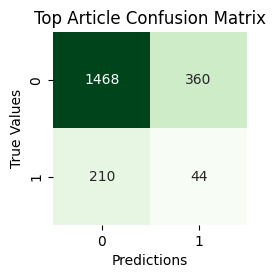

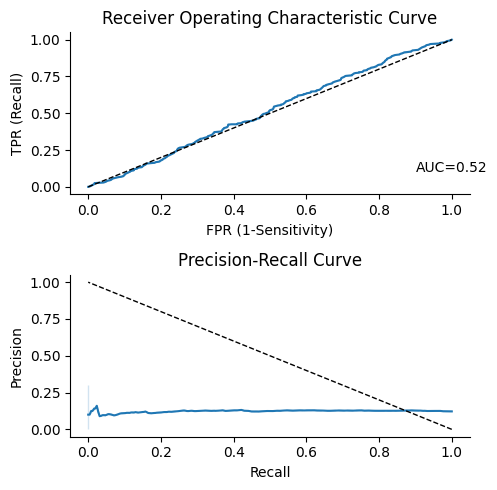

In [24]:
# evaluate model performance
accuracy = smetrics.accuracy_score(y_test, preds)
auc = smetrics.roc_auc_score(y_test, pred_probs)
print("Accuracy:", round(accuracy, 2))
print("AUC:", round(auc, 2))
print("Detail:")
print(smetrics.classification_report(y_test, preds))

cm = smetrics.confusion_matrix(y_test, preds)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Greens, cbar=False)
plt.xlabel("Predictions")
plt.ylabel("True Values")
plt.title("Top Article Confusion Matrix")

fig, ax = plt.subplots(figsize=(5, 5), nrows=2, ncols=1)
## Plot roc
fpr, tpr, thresholds = smetrics.roc_curve(y_test, pred_probs)
sns.lineplot(x=fpr, y=tpr, ax=ax[0])
ax[0].text(x=0.9, y=0.1, s='AUC={0:0.2f}'.format(auc))
ax[0].plot([0,1], [0,1], color='black', linestyle='--', lw=1)
ax[0].set(xlabel="FPR (1-Sensitivity)",
          ylabel="TPR (Recall)",
          title="Receiver Operating Characteristic Curve")
    
## Plot precision-recall curve
precision, recall, thresholds = smetrics.precision_recall_curve(y_test, pred_probs)
sns.lineplot(x=recall, y=precision, ax=ax[1])
# ax[1].text(x=0.9, y=0.1, s='AUC={0:0.2f}'.format(auc))
ax[1].plot([1,0], [0,1], color='black', linestyle='--', lw=1)
ax[1].set(xlabel="Recall",
          ylabel="Precision",
          title="Precision-Recall Curve")
fig.tight_layout()
sns.despine()

And this approach wasn't much better...

### DistilBERT Model

BERT stands for Bidirectional Encoder Representations from Transformers. It uses a Transformer model to learn contextual relationships between words in a piece of text. Transformers include an encoder to read the input text and a decoder to generate a prediction, but BERT only makes use of the encoder as the goal is to generate a language model.

A transformer model takes in an entire sequence of text all at once instead of reading it in a sequential manner from left to right. In additional, the bidirectional characteristic allows the model to look both back and forward in a piece of text to better understand the context of a particular word. This means that a pre-trained BERT model can be fine-tuned with just one additional layer to create a state-of-the-art model for a wide range of NLP tasks.

DistilBERT is a small, fast, cheap and light Transformer model trained by distilling the BERT base. It has 40% less parameters, runs 60% faster while preserving over 95% of BERT’s performances as measured on the GLUE language understanding benchmark.

In [91]:
# load the tokeniser and model
tokeniser = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [92]:
# tokenise the training text
text = train_data.title_description.copy()

tokenised_text = [tokeniser.tokenize(string) for string in text]
# identify the maximum text length
max_len = ([len(array) for array in tokenised_text])
max_len = np.max(max_len)
# BERT models can take a maximum of 512 tokens
if max_len <= 512:
    max_length = max_len
else:
    max_length = 512
print('Maximum sentence length: ', max_length)

Maximum sentence length:  122


Like most large language models, DistilBERT likes input in a specific format. A BERT model needs the following tokens:

1. [CLS] or Classification. It represents sentence-level classification and is added to the beginning of each sentence.
2. [SEP]. Added at the end of each sentence.
3. [PAD] or Padding. Used to ensure each sentence is the same length.

For example:
[CLS] Sentence A with [PAD] [SEP] [CLS] Sentence B with [PAD] [SEP]

In [ ]:
# convert the text data into an array of encoded sequences
X_train = [tokeniser.encode_plus(
    string,
    add_special_tokens=True, # add [CLS] and [SEP]
    max_length=max_length,   # pad and truncate all strings
    pad_to_max_length=True,
    truncation=True,
    return_attention_mask=True,
    ) for string in text]

# create tensors of token indices for each text string
input_ids = [x['input_ids'] for x in X_train]
train_input_id_tensors = tf.convert_to_tensor(input_ids)
# repeat for the attention maks
masks = [x['attention_mask'] for x in X_train]
train_mask_tensors = tf.convert_to_tensor(masks)

In [53]:
print("raw text: ", text[4598])
print("-----")
print("tokenised text: ", tokenised_text[3])
print("-----")
print("token ids: ", X_train[3]['input_ids'])
print("-----")
print("decoded token ids: ", tokeniser.decode(X_train[3]['input_ids']))
print("-----")
print("attention mask: ", X_train[3]['attention_mask'])

raw text:  Five Cities: Living on $50K a Year How far does the average entry-level salary go? It depends a lot on where you live.
-----
tokenised text:  ['five', 'cities', ':', 'living', 'on', '$', '50', '##k', 'a', 'year', 'how', 'far', 'does', 'the', 'average', 'entry', '-', 'level', 'salary', 'go', '?', 'it', 'depends', 'a', 'lot', 'on', 'where', 'you', 'live', '.']
-----
token ids:  [101, 2274, 3655, 1024, 2542, 2006, 1002, 2753, 2243, 1037, 2095, 2129, 2521, 2515, 1996, 2779, 4443, 1011, 2504, 10300, 2175, 1029, 2009, 9041, 1037, 2843, 2006, 2073, 2017, 2444, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
-----
decoded token ids:  [CLS] five cities : living on $ 50k a year how far does the average entry - level salary go? it depends a lot on where you

In [54]:
# repeat for the test data
text = test_data.title_description.copy()

X_test = [tokeniser.encode_plus(
    string,
    add_special_tokens=True, # add [CLS] and [SEP]
    max_length=max_length,   # pad and truncate all strings
    pad_to_max_length=True,
    truncation=True,
    return_attention_mask=True,
    ) for string in text]

# create tensors of token indices for each text string
input_ids = [x['input_ids'] for x in X_test]
test_input_id_tensors = tf.convert_to_tensor(input_ids)
# repeat for the attention maks
masks = [x['attention_mask'] for x in X_test]
test_mask_tensors = tf.convert_to_tensor(masks)

In [55]:
print("Train input shape: ", train_input_id_tensors.shape)
print("Train mask shape: ", train_mask_tensors.shape)
print("Train label shape: ", train_data.top_article.values.shape)
print("Test input shape: ", test_input_id_tensors.shape)
print("Test mask shape: ", test_mask_tensors.shape)
print("Test label shape: ", test_data.top_article.values.shape)

Train input shape:  (8327, 122)
Train mask shape:  (8327, 122)
Train label shape:  (8327,)
Test input shape:  (2082, 122)
Test mask shape:  (2082, 122)
Test label shape:  (2082,)


In [82]:
# initialise the base model
DROPOUT = 0.2
ATT_DROPOUT = 0.2

# configure DistilBERT's initialisation
config = transformers.DistilBertConfig(dropout=DROPOUT,
                                       attention_dropout=ATT_DROPOUT,
                                       output_hidden_states=True,
                                       num_labels=2)

transformer_model = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)
# note that we could have chosen a classification-specific model: TFDistilBertForSequenceClassification.
# this adds a task-specific head

# make the distilBERT layers untrainable
for layer in transformer_model.layers:
    layer.trainable=False

# define some more parameters
MAX_LENGTH = max_length
LAYER_DROPOUT = 0.2
LEARNING_RATE = 2e-5

# define the input layers
input_ids = layers.Input(shape=(MAX_LENGTH,), name='input_ids', dtype='int32')
input_masks = layers.Input(shape=(MAX_LENGTH,), name='attention_mask', dtype='int32')

# DistilBERT outputs a tuple where the first element at index 0
# represents the hidden-state at the output of the model's last layer.
# It is a tf.Tensor of shape (batch_size, sequence_length, hidden_size=768).
transformer_layer = transformer_model([input_ids, input_masks])[0]

# We only care about DistilBERT's output for the [CLS] token, which is located at index 0 of every encoded sequence.  
# Splicing out the [CLS] tokens gives us 2D data.
# don't need this layer if using a max-pooling layer
cls_token = transformer_layer[:, 0, :]

# define additional layers here
# X = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(transformer_layer)
# X = layers.GlobalMaxPool1D()(X)
X = layers.Dense(64, activation='relu')(cls_token)
X = layers.Dropout(LAYER_DROPOUT)(X)
X = layers.Dense(32, activation='relu')(X)
X = layers.Dropout(LAYER_DROPOUT)(X)

# define a single node making up the output layer
output = layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)(X)
# output = layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)(X)

# define the model
model = models.Model([input_ids, input_masks], output)

# compile the model
model.compile(optimizer=optimizers.Adam(lr=LEARNING_RATE), metrics=[METRICS], loss='categorical_crossentropy')

model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 122)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 122)]        0           []                               
                                                                                                  
 tf_distil_bert_model_21 (TFDis  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 tilBertModel)                  ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 122, 768),                                                   
                                 hidden_states=((No                                        

In [84]:
# add a callback
es = callbacks.EarlyStopping(monitor='val_prc', mode='max', verbose=1, patience=5)

# fit the model to the training data
history = model.fit([train_input_id_tensors, train_mask_tensors], train_data.top_article.values,
                    batch_size=256, epochs=5,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[es],
                    class_weight=class_weight)

Epoch 1/5
27/27 [==============================] - 401s 15s/step - loss: 0.0000e+00 - auc: 0.4818 - prc: 0.1118 - accuracy: 0.8800 - val_loss: 0.0000e+00 - val_auc: 0.4891 - val_prc: 0.1282 - val_accuracy: 0.8697
Epoch 2/5
27/27 [==============================] - 401s 15s/step - loss: 0.0000e+00 - auc: 0.4958 - prc: 0.1168 - accuracy: 0.8800 - val_loss: 0.0000e+00 - val_auc: 0.4956 - val_prc: 0.1306 - val_accuracy: 0.8697
Epoch 3/5
27/27 [==============================] - 401s 15s/step - loss: 0.0000e+00 - auc: 0.5187 - prc: 0.1258 - accuracy: 0.8800 - val_loss: 0.0000e+00 - val_auc: 0.5040 - val_prc: 0.1355 - val_accuracy: 0.8697
Epoch 4/5
27/27 [==============================] - 402s 15s/step - loss: 0.0000e+00 - auc: 0.5107 - prc: 0.1231 - accuracy: 0.8800 - val_loss: 0.0000e+00 - val_auc: 0.5128 - val_prc: 0.1403 - val_accuracy: 0.8697
Epoch 5/5
27/27 [==============================] - 403s 15s/step - loss: 0.0000e+00 - auc: 0.5032 - prc: 0.1217 - accuracy: 0.8800 - val_loss: 0.000

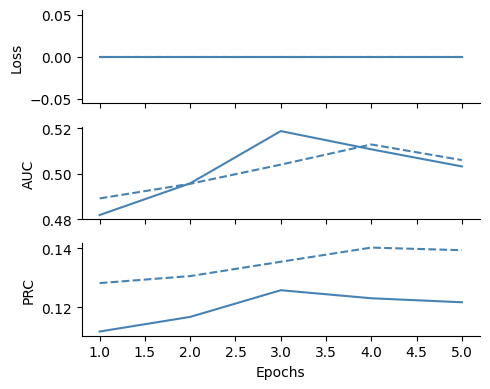

In [85]:
metrics = [k for k in history.history.keys() if ("loss" not in k) and ("val" not in k)]

fig, ax = plt.subplots(figsize=(5, 4), nrows=3, ncols=1, sharex=True)
# plot loss
sns.lineplot(x=[i+1 for i in range(len(history.history['loss']))], y=history.history['loss'], ax=ax[0], color='steelblue')
sns.lineplot(x=[i+1 for i in range(len(history.history['val_loss']))], y=history.history['val_loss'], ax=ax[0], color='steelblue',
             linestyle='dashed')
ax[0].set(xlabel="Epochs", ylabel="Loss")

# plot AUC
sns.lineplot(x=[i+1 for i in range(len(history.history['auc']))], y=history.history['auc'], ax=ax[1], color='steelblue')
sns.lineplot(x=[i+1 for i in range(len(history.history['val_auc']))], y=history.history['val_auc'], ax=ax[1], color='steelblue',
             linestyle='dashed')
ax[1].set(xlabel="Epochs", ylabel="AUC")

# plot PRC
sns.lineplot(x=[i+1 for i in range(len(history.history['prc']))], y=history.history['prc'], ax=ax[2], color='steelblue')
sns.lineplot(x=[i+1 for i in range(len(history.history['val_prc']))], y=history.history['val_prc'], ax=ax[2], color='steelblue',
             linestyle='dashed')
ax[2].set(xlabel="Epochs", ylabel="PRC")

fig.tight_layout()
sns.despine()

In [86]:
# evaluate performance on the test set
pred_probs = model.predict([test_input_id_tensors, test_mask_tensors])
preds = np.where(pred_probs > 0.5, 1,0)

66/66 [==============================] - 72s 1s/step


Accuracy: 0.88
AUC: 0.54
Detail:
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94      1828
         1.0       0.00      0.00      0.00       254

    accuracy                           0.88      2082
   macro avg       0.44      0.50      0.47      2082
weighted avg       0.77      0.88      0.82      2082



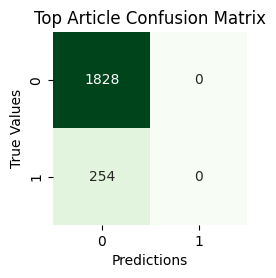

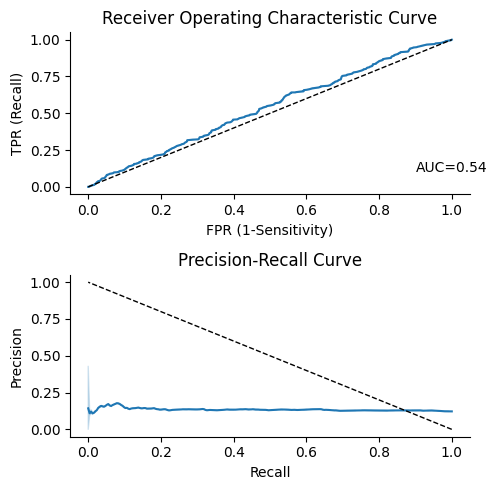

In [87]:
# evaluate model performance
y_test = test_data.top_article.values

accuracy = smetrics.accuracy_score(y_test, preds)
auc = smetrics.roc_auc_score(y_test, pred_probs)
print("Accuracy:", round(accuracy, 2))
print("AUC:", round(auc, 2))
print("Detail:")
print(smetrics.classification_report(y_test, preds))

cm = smetrics.confusion_matrix(y_test, preds)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Greens, cbar=False)
plt.xlabel("Predictions")
plt.ylabel("True Values")
plt.title("Top Article Confusion Matrix")

fig, ax = plt.subplots(figsize=(5, 5), nrows=2, ncols=1)
## Plot roc
fpr, tpr, thresholds = smetrics.roc_curve(y_test, pred_probs)
sns.lineplot(x=fpr, y=tpr, ax=ax[0])
ax[0].text(x=0.9, y=0.1, s='AUC={0:0.2f}'.format(auc))
ax[0].plot([0,1], [0,1], color='black', linestyle='--', lw=1)
ax[0].set(xlabel="FPR (1-Sensitivity)",
          ylabel="TPR (Recall)",
          title="Receiver Operating Characteristic Curve")
    
## Plot precision-recall curve
precision, recall, thresholds = smetrics.precision_recall_curve(y_test, pred_probs)
sns.lineplot(x=recall, y=precision, ax=ax[1])
# ax[1].text(x=0.9, y=0.1, s='AUC={0:0.2f}'.format(auc))
ax[1].plot([1,0], [0,1], color='black', linestyle='--', lw=1)
ax[1].set(xlabel="Recall",
          ylabel="Precision",
          title="Precision-Recall Curve")
fig.tight_layout()
sns.despine()